# Memory Information and GPU Information



In [ ]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 12.69GB
Available: 11.87GB
Used: 568.02MB
Percentage: 6.4%


In [ ]:
! nvidia-smi

Fri May 28 18:44:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import utils

# Data

In [ ]:
train_data_ = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor()]))

In [ ]:
torch.manual_seed(1)
batch_size = 64

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_data = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation(5),
                        transforms.RandomAffine(degrees=8, translate=(0.15,0.15), scale=(0.85, 1.15)),
                        transforms.ColorJitter(brightness=0.1, contrast=0.1),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))]))
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,
                                           shuffle=True, **kwargs)

test_data = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))]))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=True, **kwargs)

In [ ]:
utils.data_stats(train_data_)

Train Statistics
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


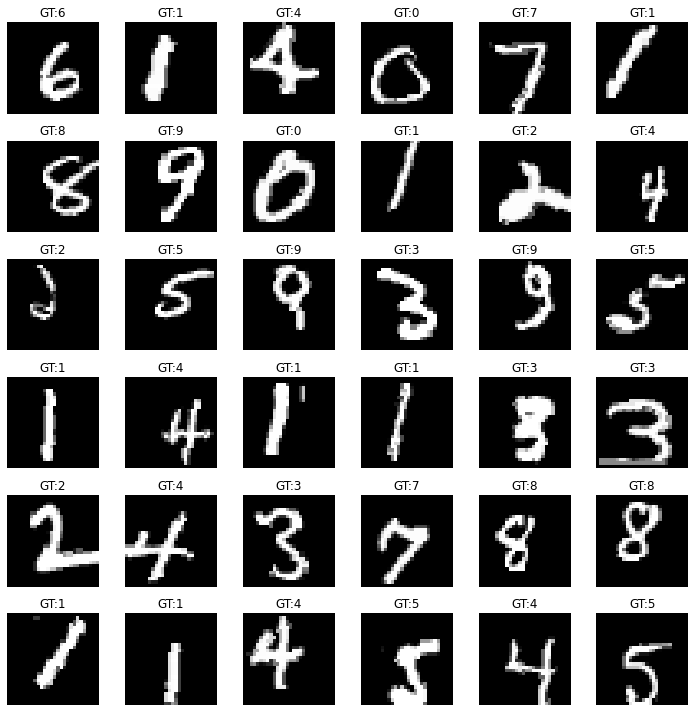

In [ ]:
class_list = [0,1,2,3,4,5,6,7,8,9]
utils.plot_data_grid(train_loader, mean= (0.1307,), std= (0.3081,), class_list=class_list, ncol=6,nrow=6)

# Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)  # 28x28x1 -> 28x28x4
        self.bn1 = nn.BatchNorm2d(num_features=4)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1)  # 28x28x4 -> 28x28x8
        self.bn2 = nn.BatchNorm2d(num_features=8)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3, padding=1)  # 28x28x8 -> 28x28x12
        self.bn3 = nn.BatchNorm2d(num_features=12)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3, padding=1)  # 28x28x12 -> 28x28x16
        self.bn4 = nn.BatchNorm2d(num_features=16)
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=20, kernel_size=3, padding=1)  # 28x28x16 -> 28x28x20
        self.bn5 = nn.BatchNorm2d(num_features=20)
        self.dropout = nn.Dropout(0.069)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 28x28x20 -> 14x14x20
        self.transition1 = nn.Conv2d(in_channels=20, out_channels=4, kernel_size=1)  # 14x14x20 -> 14x14x4
        
        self.conv6 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3)  # 14x14x4 -> 12x12x8
        self.bn6 = nn.BatchNorm2d(num_features=8)
        self.conv7 = nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3)  # 12x12x8 -> 10x10x12
        self.bn7 = nn.BatchNorm2d(num_features=12)
        self.conv8 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3)  # 10x10x12 -> 8x8x16
        self.bn8 = nn.BatchNorm2d(num_features=16)
        self.conv9 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=1)
        
        self.gap = nn.AvgPool2d(kernel_size=8)
        self.fc1 = nn.Linear(in_features=10, out_features=10)

    def forward(self, net):
        net = self.dropout(F.relu(self.conv1(net)))
        net = self.bn2(F.relu(self.conv2(net)))
        net = self.bn3(F.relu(self.conv3(net)))
        net = self.bn4(F.relu(self.conv4(net)))
        net = self.bn5(F.relu(self.conv5(net)))
        net = self.transition1(self.pool1(net))
        net = self.bn6(F.relu(self.conv6(net)))
        net = self.bn7(F.relu(self.conv7(net)))
        net = self.conv9(self.bn8(F.relu(self.conv8(net))))
        net = self.gap(net)
        net = net.view(-1,10)
        net = self.fc1(net)

        return F.log_softmax(net, dim=1)

In [ ]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
           Dropout-2            [-1, 4, 28, 28]               0
            Conv2d-3            [-1, 8, 28, 28]             296
       BatchNorm2d-4            [-1, 8, 28, 28]              16
            Conv2d-5           [-1, 12, 28, 28]             876
       BatchNorm2d-6           [-1, 12, 28, 28]              24
            Conv2d-7           [-1, 16, 28, 28]           1,744
       BatchNorm2d-8           [-1, 16, 28, 28]              32
            Conv2d-9           [-1, 20, 28, 28]           2,900
      BatchNorm2d-10           [-1, 20, 28, 28]              40
        MaxPool2d-11           [-1, 20, 14, 14]               0
           Conv2d-12            [-1, 4, 14, 14]              84
           Conv2d-13            [-1, 8, 12, 12]             296
      BatchNorm2d-14            [-1, 8,

# Train and Test

In [ ]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

    train_loss /= len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)

    return train_loss, accuracy

In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    return test_loss, accuracy

# Training

In [ ]:
from torch.optim.lr_scheduler import StepLR

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size= 8, gamma= 0.25)

train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(1, 20):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train(model, device, train_loader, optimizer)
    test_loss, test_acc = test(model, device, test_loader)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    scheduler.step()
    
    print('\nTRAIN set: Average loss: {:.4f}, Train Accuracy: {:.2f}%'.format(train_loss,train_acc))
    print('TEST set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss,test_acc))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.5684, Train Accuracy: 81.37%
TEST set: Average loss: 0.0771, Test Accuracy: 97.86%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.1425, Train Accuracy: 96.00%
TEST set: Average loss: 0.0832, Test Accuracy: 97.40%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.1065, Train Accuracy: 96.90%
TEST set: Average loss: 0.0357, Test Accuracy: 98.94%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0889, Train Accuracy: 97.44%
TEST set: Average loss: 0.0291, Test Accuracy: 99.06%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0794, Train Accuracy: 97.66%
TEST set: Average loss: 0.0275, Test Accuracy: 99.13%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0726, Train Accuracy: 97.81%
TEST set: Average loss: 0.0275, Test Accuracy: 99.11%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 7


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0687, Train Accuracy: 97.97%
TEST set: Average loss: 0.0282, Test Accuracy: 99.03%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 8


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0642, Train Accuracy: 98.09%
TEST set: Average loss: 0.0278, Test Accuracy: 99.13%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 9


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0520, Train Accuracy: 98.46%
TEST set: Average loss: 0.0196, Test Accuracy: 99.43%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 10


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0504, Train Accuracy: 98.52%
TEST set: Average loss: 0.0189, Test Accuracy: 99.38%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 11


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0486, Train Accuracy: 98.54%
TEST set: Average loss: 0.0196, Test Accuracy: 99.36%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 12


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0467, Train Accuracy: 98.57%
TEST set: Average loss: 0.0187, Test Accuracy: 99.45%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 13


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0445, Train Accuracy: 98.62%
TEST set: Average loss: 0.0168, Test Accuracy: 99.50%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 14


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0439, Train Accuracy: 98.69%
TEST set: Average loss: 0.0173, Test Accuracy: 99.48%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 15


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0440, Train Accuracy: 98.71%
TEST set: Average loss: 0.0176, Test Accuracy: 99.43%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 16


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0448, Train Accuracy: 98.64%
TEST set: Average loss: 0.0179, Test Accuracy: 99.50%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 17


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0425, Train Accuracy: 98.69%
TEST set: Average loss: 0.0160, Test Accuracy: 99.52%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 18


  0%|          | 0/938 [00:00<?, ?it/s]


TRAIN set: Average loss: 0.0415, Train Accuracy: 98.78%
TEST set: Average loss: 0.0156, Test Accuracy: 99.54%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 19


loss=0.029502948746085167 batch_id=937: 100%|██████████| 938/938 [00:39<00:00, 23.49it/s]



TRAIN set: Average loss: 0.0414, Train Accuracy: 98.75%
TEST set: Average loss: 0.0159, Test Accuracy: 99.57%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [ ]:
print('Train Accuracy:', max(train_acc_list))
print('Test Accuracy:', max(test_acc_list))

Train Accuracy: 98.775
Test Accuracy: 99.57


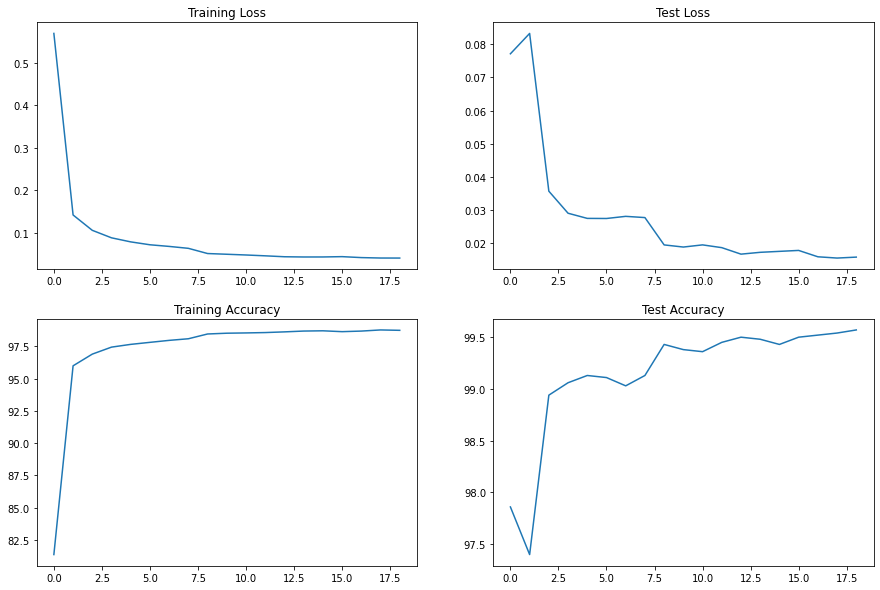

In [ ]:
utils.plot_loss_acc(train_loss_list, train_acc_list, test_loss_list, test_acc_list)

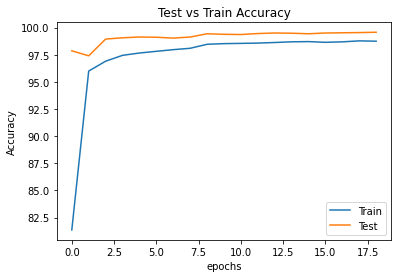

In [ ]:
utils.plot_combined(train_acc_list, test_acc_list)

In [ ]:
images, labels = next(iter(test_loader))
output = model(images.to(device))
predicted = output.argmax(dim=1, keepdim=True).squeeze()

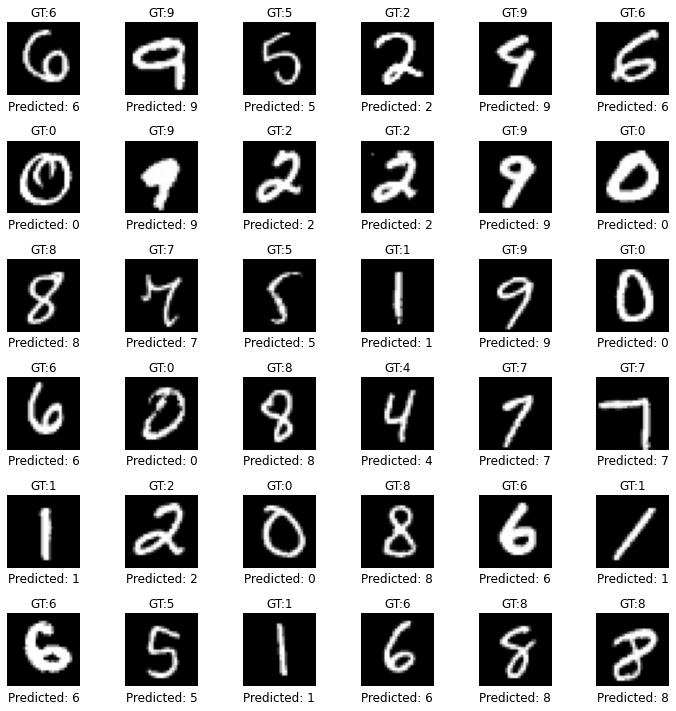

In [ ]:
class_list = [0,1,2,3,4,5,6,7,8,9]
utils.plot_results(images, predicted, labels, mean=(0.1307,), std= (0.3081,), class_list=class_list, ncol=6,nrow=6)

# Model Architecture

In [ ]:
!pip3 install graphviz
!pip3 install hiddenlayer

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:680: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:680: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


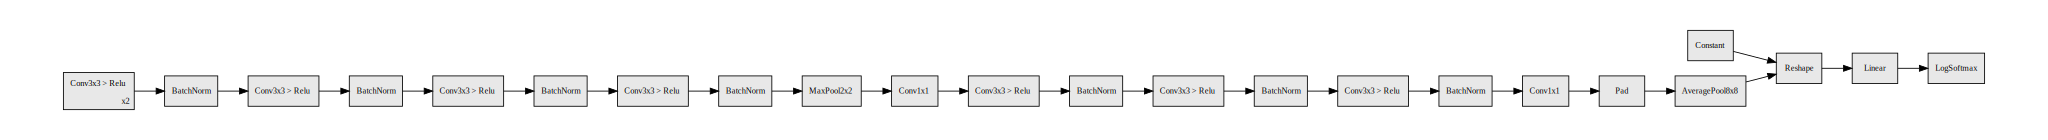

In [ ]:
import hiddenlayer as hl
model = Net().to('cuda')
network_graph = hl.build_graph(model, torch.zeros([1, 1, 28, 28]).to('cuda'))
network_graph.save("./images/network_1", "png")
network_graph